In [1]:
import argparse
import os
import random
import torch
import utils
import visualization

import numpy as np

from models.model import VICE
from typing import Tuple

In [2]:
#!pip install -r './requirements.txt'

### Variables

In [3]:
# define variables
task = 'odd_one_out' # 3AFC
modality = 'behavioral'
triplets_dir = './triplets/behavioral/05/split_01/'
results_dir = './test_vice_01/'
plots_dir = './test_vice_01/'
epochs = 3
latent_dim = 50 # initial latent dimensionality of VICE
batch_size = 128 # use power of 2 if you intend to perfrom model training on a GPU, else see what works best
optim = 'adam'
prior = 'gaussian' # spike-and-slab Gaussian mixture prior
mc_samples = 10
eta = 1e-3 # learning rate used in optimizer
spike = 0.1 # sigma_spike
slab = 1.0 # sigma_slab
pi = 0.5
steps = 2
seed = 42
verbose = True

In [4]:
# seed rng
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(seed)
else:
    device = torch.device('cpu')

In [5]:
# load train and test triplets into memory
train_triplets, test_triplets = utils.load_data(device=device, triplets_dir=triplets_dir)

# get number of trials and number of unique items in the data
N = train_triplets.shape[0]
n_items = utils.get_nitems(train_triplets)

# load mini-batches for training
train_batches, val_batches = utils.load_batches(
                                                train_triplets=train_triplets,
                                                test_triplets=test_triplets,
                                                n_items=n_items,
                                                batch_size=batch_size,
                                                inference=False,
    )

#### Helper function to create directories

In [6]:
def create_dirs(
                results_dir: str,
                plots_dir: str,
                modality: str,
                latent_dim: int,
                optim: str,
                prior: str,
                spike: float,
                slab: float,
                pi: float,
                rnd_seed: int,
) -> Tuple[str, str, str]:
    """Create directories for results, plots, and model parameters."""
    print('\n...Creating directories.\n')
    if results_dir == './results/':
        results_dir = os.path.join(
                                    results_dir,
                                    modality,
                                    f'{latent_dim}d',
                                    optim,
                                    prior,
                                    str(spike),
                                    str(slab),
                                    str(pi),
                                    f'seed{rnd_seed:02d}',
        )
    if not os.path.exists(results_dir):
        os.makedirs(results_dir, exist_ok=True)
        
    if plots_dir == './plots/':
        plots_dir = os.path.join(
                                 plots_dir,
                                 modality,
                                 f'{latent_dim}d',
                                 optim,
                                 prior,
                                 str(spike),
                                 str(slab),
                                 str(pi),
                                 f'seed{rnd_seed:02d}',
        )
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir, exist_ok=True)
        
    model_dir = os.path.join(results_dir, 'model')
    return results_dir, plots_dir, model_dir

In [7]:
results_dir, plots_dir, model_dir = create_dirs(
                                                results_dir=results_dir,
                                                plots_dir=plots_dir,
                                                modality=modality,
                                                latent_dim=latent_dim,
                                                optim=optim,
                                                prior=prior,
                                                spike=spike,
                                                slab=slab,
                                                pi=pi,
                                                rnd_seed=seed,
                                            )


...Creating directories.



In [8]:
# initialize VICE
vice = VICE(
            task=task,
            n_train=N,
            n_items=n_items,
            latent_dim=latent_dim,
            optim=optim,
            eta=eta,
            batch_size=batch_size,
            epochs=epochs,
            mc_samples=mc_samples,
            prior=prior,
            spike=spike,
            slab=slab,
            pi=pi,
            steps=steps,
            model_dir=model_dir,
            results_dir=results_dir,
            device=device,
            verbose=verbose,
            init_weights=True,
    )
# move VICE to current device
vice.to(device)

VICE(
  (encoder_mu): Linear(in_features=1854, out_features=50, bias=False)
  (encoder_logsigma): Linear(in_features=1854, out_features=50, bias=False)
)

In [9]:
# perform VICE training
vice.fit(train_batches=train_batches, val_batches=val_batches)


====== Epoch: 1, Train acc: 0.333, Train loss: 5.204 ======


====== Epoch: 2, Train acc: 0.368, Train loss: 4.122 ======


====== Epoch: 3, Train acc: 0.356, Train loss: 3.395 ======



In [10]:
# get train and validation prediction accuracies, log-likelihoods, and complexity losses (KLDs)
train_accs = vice.train_accs
val_accs = vice.val_accs
loglikelihoods = vice.loglikelihoods
complexity_losses = vice.complexity_losses

/Users/lmuttenthaler/GitHub/VICE/visualization.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


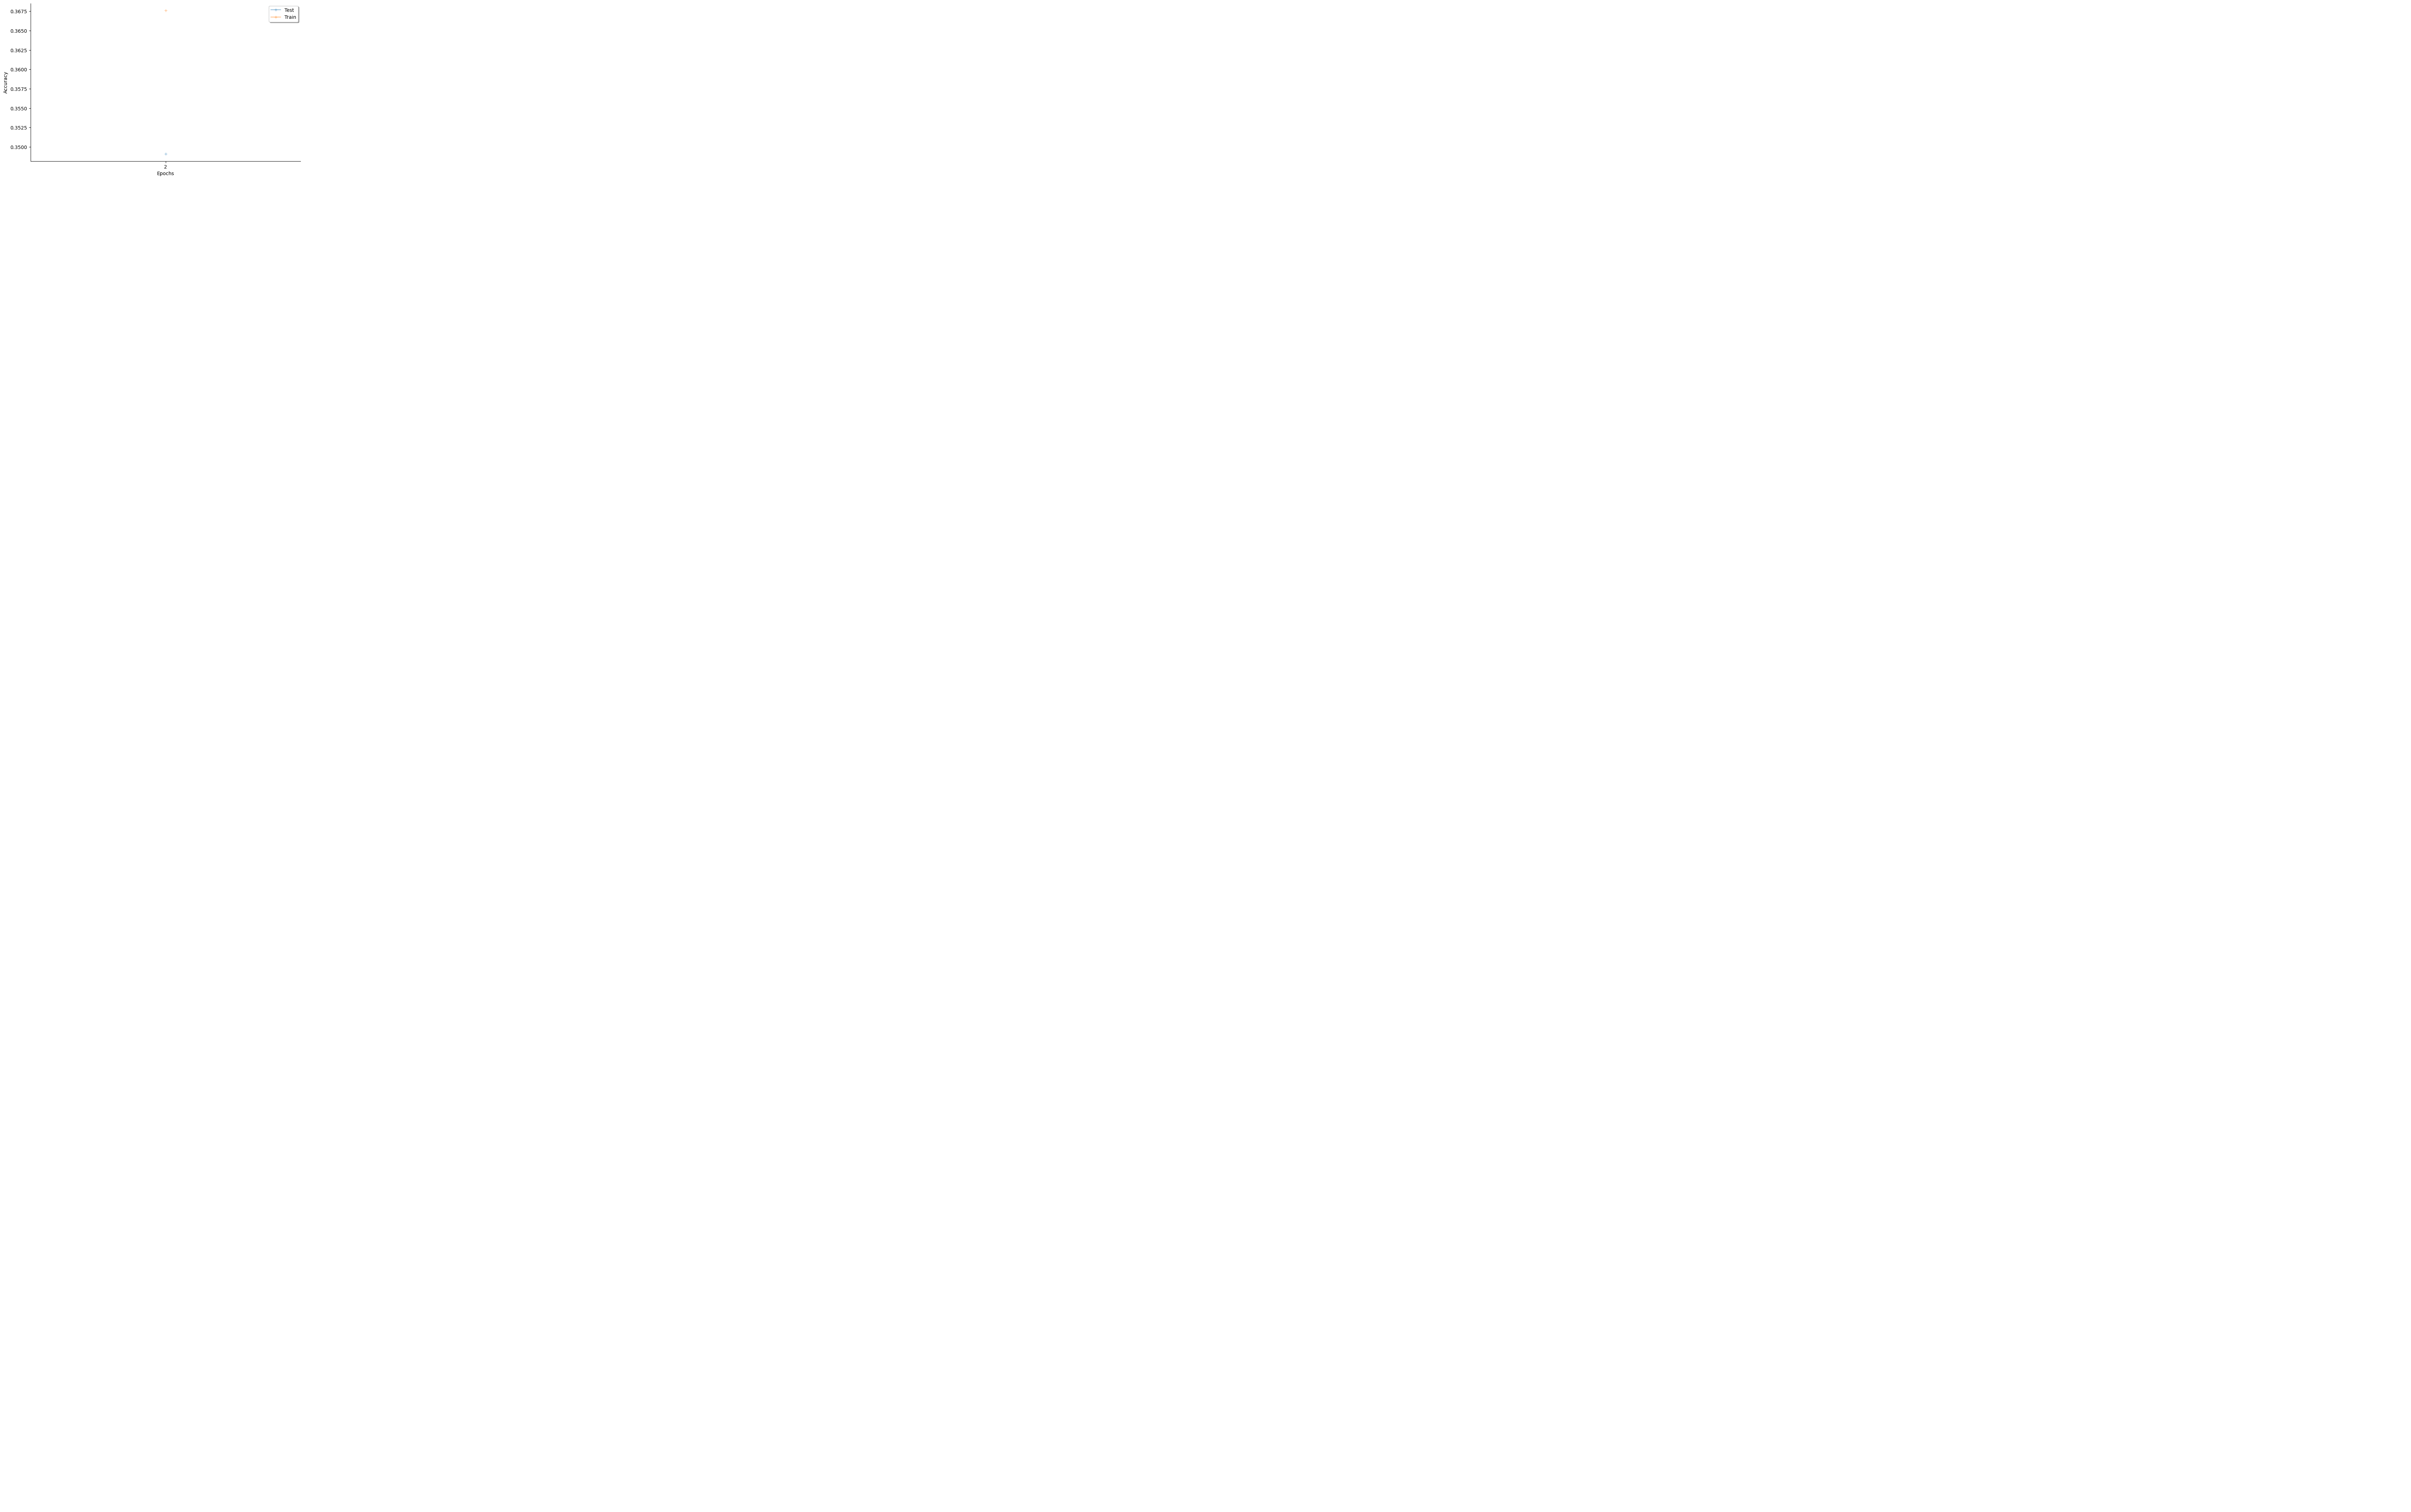

In [11]:
visualization.plot_single_performance(
                                        plots_dir=plots_dir,
                                        val_accs=val_accs,
                                        train_accs=train_accs,
                                        steps=steps,
                                        show_plot=True
)


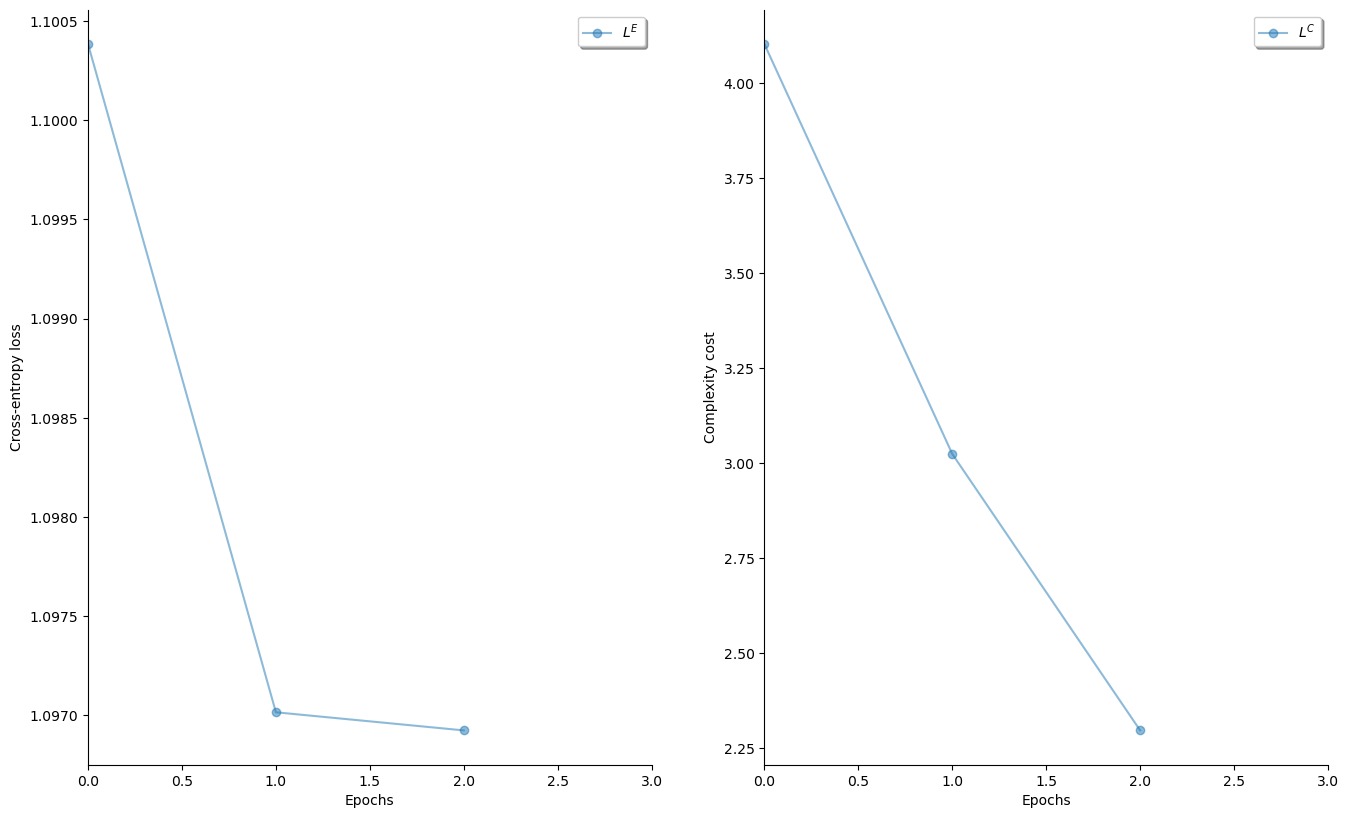

In [12]:
visualization.plot_complexities_and_loglikelihoods(
                                                    plots_dir=plots_dir,
                                                    loglikelihoods=loglikelihoods,
                                                    complexity_losses=complexity_losses,
                                                    show_plot=True
)

In [13]:
# get model parameters
params = vice.detached_params
W_loc=params['loc']
W_scale=params['scale']

In [14]:
# compress model params and store as binary files
#with open(os.path.join(results_dir, 'parameters.npz'), 'wb') as f:
#    np.savez_compressed(f, W_loc=W_loc, W_scale=W_scale)